In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/privacy_permutation/')

Mounted at /content/drive


In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

#from torchsummary import summary
%pip install torchinfo -q
from torchinfo import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

import scipy.signal as signal

import utils

# %matplotlib widget
%matplotlib notebook
%matplotlib inline

<ipython-input-2-d55e5e28eb96>:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [3]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
utils.setup_seed(1312)

In [4]:
img_size = 33

test = utils.Permutar(img_size, 1)
test.key.reshape(33,33)

array([[ 608,  275,  171, ...,  160,  829,  751],
       [ 543,  230,  739, ...,  541,  695,  156],
       [ 712,  539,   68, ...,  786,   64, 1007],
       ...,
       [ 902,  175,  855, ...,  808,  682,  526],
       [ 581, 1078,  409, ...,  388,  278,  237],
       [  90,   30,  375, ...,  791,  176,   81]])

dataloader

In [36]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform=transforms.Compose([
    T.Resize((33,33)),
    T.ToTensor(),
    T.Normalize((0.1307,), (0.3081,))
    ])

trainset = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform,)
testset = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

#editar esto
permutar = False
classes = testset.classes
classes1 = trainset.classes
if permutar:

    fake_loader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=False,drop_last=True)
    a = list(fake_loader)
    b = test.desordenar(a[0][0])
    trainset = torch.utils.data.TensorDataset(b,a[0][1])
    trainset.classes = classes1

    fake_loader2 = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False,drop_last=True)
    a2 = list(fake_loader2)
    b2 = test.desordenar(a2[0][0])
    testset = torch.utils.data.TensorDataset(b2,a2[0][1])
    testset.classes = classes

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, drop_last=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, drop_last=True)

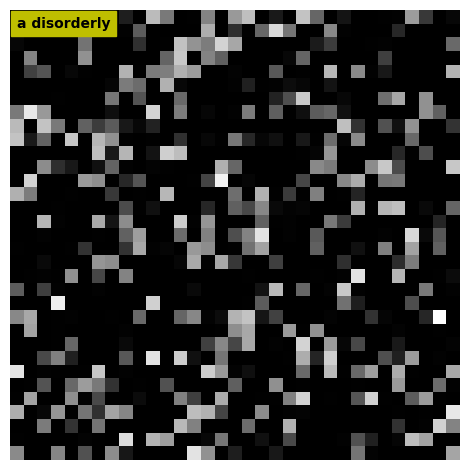

In [6]:
a = next(iter(train_loader))
X,y = [a[0][0], a[1][0]]


pic = X.data.cpu().numpy().transpose((1,2,0))
pic = pic-np.min(pic) # undo normalization
pic = pic/np.max(pic)

label = "a"#testset.classes[y]

plt.imshow(pic, cmap='gray')
plt.text(0,0,f'{label} disorderly',ha='left',va='top',fontweight='bold',color='k',backgroundcolor='y')

plt.axis('off')

plt.tight_layout()
plt.show()

### network

In [33]:
from permuted_newtork import PermutedNetwork_2, PermutedNetwork, NormalNetwork, NormalNetwork_latentspace

model = NormalNetwork().to(device)
model.load_state_dict(torch.load('model_weights.pth'), strict=True)

model1 = NormalNetwork_latentspace().to(device)

encoder = model.encoder

encoder.eval()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): AdaptiveAvgPool2d(output_size=(5, 5))
)

In [20]:
summary(model1,(1,1,33,33))

Layer (type:depth-idx)                   Output Shape              Param #
NormalNetwork_latentspace                [1, 64, 5, 5]             --
├─Sequential: 1-1                        [1, 64, 5, 5]             --
│    └─Conv2d: 2-1                       [1, 16, 33, 33]           160
│    └─ReLU: 2-2                         [1, 16, 33, 33]           --
│    └─MaxPool2d: 2-3                    [1, 16, 16, 16]           --
│    └─Conv2d: 2-4                       [1, 32, 16, 16]           4,640
│    └─ReLU: 2-5                         [1, 32, 16, 16]           --
│    └─MaxPool2d: 2-6                    [1, 32, 8, 8]             --
│    └─Conv2d: 2-7                       [1, 64, 8, 8]             18,496
│    └─ReLU: 2-8                         [1, 64, 8, 8]             --
│    └─AdaptiveAvgPool2d: 2-9            [1, 64, 5, 5]             --
Total params: 23,296
Trainable params: 23,296
Non-trainable params: 0
Total mult-adds (M): 2.55
Input size (MB): 0.00
Forward/backward pass size (M

In [21]:
# Define the loss
criterion = nn.MSELoss()#nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

In [39]:
# Train the network
epochs = 7

trainLoss = torch.zeros(epochs)
testLoss  = torch.zeros(epochs)
trainAcc  = torch.zeros(epochs)
testAcc   = torch.zeros(epochs)

for e in range(epochs):
    model.train()

    batchLoss = []
    #batchAcc  = []

    for images, labels in train_loader:

        optimizer.zero_grad()

        images = images.to(device)
        labels = encoder(images).to(device)

        images = test.desordenar(images)
        output = model1(images)

        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()

        batchLoss.append(loss.item())
        #batchAcc.append( (output.argmax(dim=1) == labels).type(torch.float).mean() )

    trainLoss[e] = torch.tensor(batchLoss).mean()
    trainAcc[e]  = torch.tensor(batchAcc).mean()

    model.eval()
    batchLoss = []
    #batchAcc  = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device) #test.desordenar(images).to(device)
            labels =  encoder(images).to(device)
            output = model1(images)
            loss = criterion(output, labels)
            batchLoss.append(loss.item())
            #batchAcc.append((output.argmax(dim=1) == labels).type(torch.float).mean())

    testLoss[e] = torch.tensor(batchLoss).mean()
    #testAcc[e]  = torch.tensor(batchAcc).mean()

    print(f"Epoch {e+1}/{epochs} Test Loss: {testLoss[e]:.3f} , Train Loss: {trainLoss[e]:.3f}")



Epoch 1/7 Test Loss: 0.232 , Train Loss: 0.238
Epoch 2/7 Test Loss: 0.232 , Train Loss: 0.238
Epoch 3/7 Test Loss: 0.232 , Train Loss: 0.238
Epoch 4/7 Test Loss: 0.232 , Train Loss: 0.238
Epoch 5/7 Test Loss: 0.232 , Train Loss: 0.238
Epoch 6/7 Test Loss: 0.232 , Train Loss: 0.238
Epoch 7/7 Test Loss: 0.232 , Train Loss: 0.238


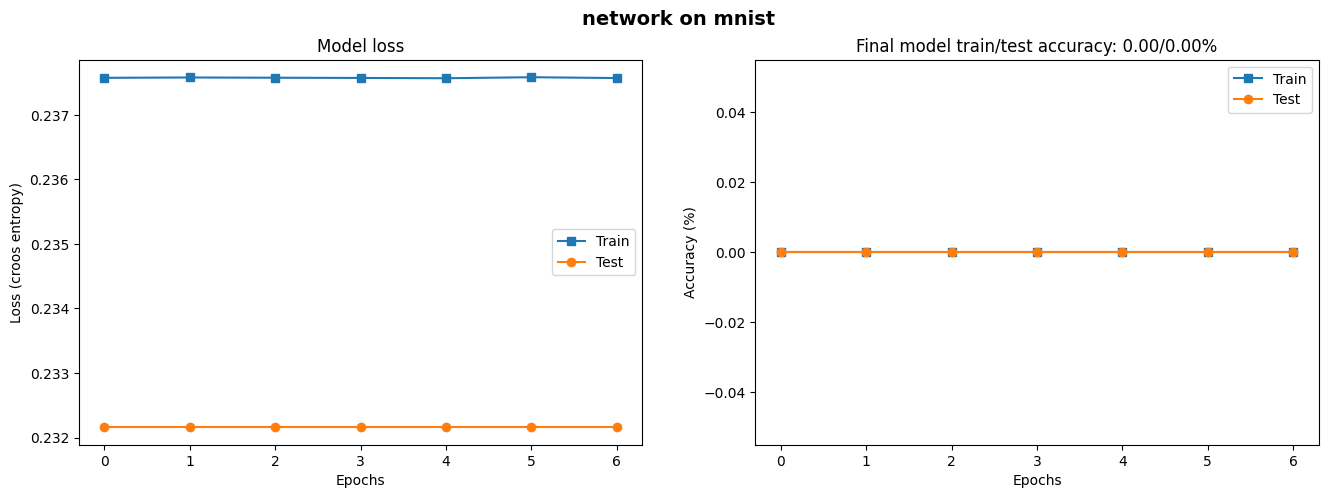

In [40]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (croos entropy)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('network on mnist',fontweight='bold',fontsize=14)
plt.show()

tensor(-0.5325, device='cuda:0', grad_fn=<MinBackward1>)


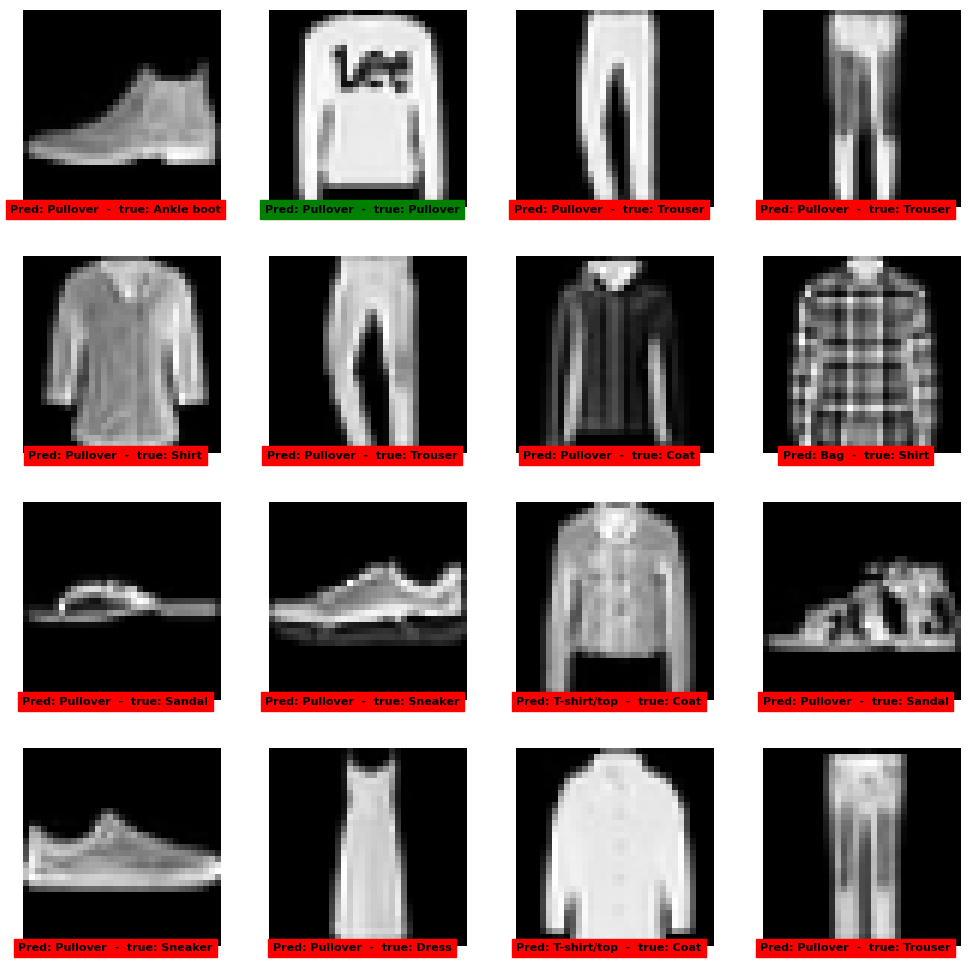

In [42]:
X,y = next(iter(test_loader))

X = X.to(device) #test.desordenar(X).to(device)
y = y.to(device)

latent_s = model1(X)
latent_e_s = encoder(X)

print(torch.min( latent_e_s - latent_s) )

output = model.fc(latent_s.flatten(start_dim=1))


predictions = torch.argmax( output ,axis=1)


fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  pic = X.data[i].cpu().numpy().transpose((1,2,0))
  pic = pic-np.min(pic) # undo normalization
  pic = pic/np.max(pic)

  ax.imshow(pic, cmap='gray')


  # label and true class
  #print(i)
  label = trainset.classes[predictions[i]]
  truec = trainset.classes[y[i]]
  title = f'Pred: {label}  -  true: {truec}'

  # set the title with color-coded accuracy
  titlecolor = 'g' if truec==label else 'r'
  ax.text(15,32,title,ha='center',va='top',fontweight='bold',color='k',backgroundcolor=titlecolor,fontsize=8)
  ax.axis('off')

plt.tight_layout()
plt.show()

ignorar aqui abajo

In [ ]:
# test
model.eval()
batchLoss = []
batchAcc  = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device) # test.desordenar(images).to(device)
        labels = labels.to(device)

        output = model(images)
        loss = criterion(output, labels)
        batchLoss.append(loss.item())
        batchAcc.append((output.argmax(dim=1) == labels).type(torch.float).mean())

testLoss = torch.tensor(batchLoss).mean()
testAcc  = torch.tensor(batchAcc).mean()

print(testLoss,testAcc)

tensor(0.2701) tensor(0.9162)


In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')